In [1]:
import warnings
import os
from numpy.linalg import LinAlgError
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time
import datetime
import copy
import argparse
import fooof
import math
import CanonParam.parameterize_spectra
# from joblib import Parallel, delayed

In [2]:

class SpecParamError(Exception):
    """Base class for custom errors."""

class FitError(SpecParamError):
    """Error for a failure to fit."""

class NoDataError(SpecParamError):
    """Error for if data is missing."""

class DataError(SpecParamError):
    """Error for if there is a problem with the data."""

class InconsistentDataError(SpecParamError):
    """Error for if the data is inconsistent."""

class IncompatibleSettingsError(SpecParamError):
    """Error for if settings are incompatible."""

class NoModelError(SpecParamError):
    """Error for if the model is not fit."""


class ParamSpectra():
    # implement FOOOF but allow for predefined bandwindows
    def __init__(self, bands='standard',  max_n_peaks=6, log_freqs=True, n_division=1, l_freq=0.3, h_freq=250, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1):
        """Model a power spectrum as a combination of aperiodic and periodic components.

        WARNING: frequency and power values inputs must be in linear space.

        Passing in logged frequencies and/or power spectra is not detected,
        and will silently produce incorrect results.

        Parameters
        ----------
        bands : str or list of [float, float] pairs, optional, default: 'standard'.
            Possible options (see str2band for implementation details): 'standard', 'log', 'linear', 'log10', 'mine', 'mine_nohigh', 'anton', 'buzsaki'
        max_n_peaks : int, optional, default: 6, only used if bands is a specified as "log" or "linear"
            Maximum number of peaks to fit.
        log_freqs : bool, optional, default: True
            Whether or not the input frequencies are in natural log space.
        n_division : int, optional, default: 1
            Number of divisions to split each frequency band into.
        aperiodic_mode : {'fixed', 'knee'}
            Which approach to take for fitting the aperiodic component.
       
        l_freq : float, optional, default: 0.3
            The lowest frequency to consider in the aperiodic fit.
        h_freq : float, optional, default: 250
            The highest frequency to consider in the aperiodic fit. NOTE: must be <= sampling frequency/2 (Nyquist frequency)
        
        prominence : float, optional, default: 0.5
            The prominence value to use for peak finding of the powerline harmonics
        linenoise : float, optional, default: 60
            The base frequency of the powerline noise.
        
        verbose : bool, optional, default: True
            Verbosity mode. If True, prints out warnings and general status updates.


        Attributes
        ----------
        freqs : 1d array
            Frequency values for the power spectrum.
        power_spectrum : 1d array
            Power values, stored internally in log10 scale.
        freq_range : list of [float, float]
            Frequency range of the power spectrum, as [lowest_freq, highest_freq].
        freq_res : float
            Frequency resolution of the power spectrum.
        modeled_spectrum_ : 1d array
            The full model fit of the power spectrum, in log10 scale.
        aperiodic_params_ : 1d array
            Parameters that define the aperiodic fit. As [Offset, (Knee), Exponent].
            The knee parameter is only included if aperiodic component is fit with a knee.
        peak_params_ : 2d array
            Fitted parameter values for the peaks. Each row is a peak, as [CF, PW, BW].
        gaussian_params_ : 2d array
            Parameters that define the gaussian fit(s).
            Each row is a gaussian, as [mean, height, standard deviation].
        r_squared_ : float
            R-squared of the fit between the input power spectrum and the full model fit.
        error_ : float
            Error of the full model fit.
        n_peaks_ : int
            The number of peaks fit in the model.
        has_data : bool
            Whether data is loaded to the object.
        has_model : bool
            Whether model results are available in the object.

        Notes
        -----
        - Commonly used abbreviations used in this module include:
        CF: center frequency, PW: power, BW: Bandwidth, AP: aperiodic
        - Input power spectra must be provided in linear scale.
        Internally they are stored in log10 scale, as this is what the model operates upon.
        - Input power spectra should be smooth, as overly noisy power spectra may lead to bad fits.
        For example, raw FFT inputs are not appropriate. Where possible and appropriate, use
        longer time segments for power spectrum calculation to get smoother power spectra,
        as this will give better model fits.
        - The gaussian params are those that define the gaussian of the fit, where as the peak
        params are a modified version, in which the CF of the peak is the mean of the gaussian,
        the PW of the peak is the height of the gaussian over and above the aperiodic component,
        and the BW of the peak, is 2*std of the gaussian (as 'two sided' bandwidth).
        """


        self.bands = bands
        self.l_freq = l_freq
        self.h_freq = h_freq
        self.aperiodic_mode = aperiodic_mode
        self.verbose = verbose
        self.log_freqs = log_freqs
        self.n_division = n_division
        self.linenoise = linenoise
        self.prominence = prominence
        self.max_n_peaks = max_n_peaks

        
        self.bands, self.bandname = str2band(bands, max_n_peaks=self.max_n_peaks, l_freq=l_freq, h_freq=h_freq, n_division=n_division)

        # drop bands that are above or below the frequency range
        self.bands = [band for band in self.bands if band[0] < h_freq and band[1] > l_freq]
        ## PRIVATE SETTINGS
        # Percentile threshold, to select points from a flat spectrum for an initial aperiodic fit
        #   Points are selected at a low percentile value to restrict to non-peak points
        self._ap_percentile_thresh = 0.025
        # Guess parameters for aperiodic fitting, [offset, knee, exponent]
        #   If offset guess is None, the first value of the power spectrum is used as offset guess
        #   If exponent guess is None, the abs(log-log slope) of first & last points is used
        self._ap_guess = (None, self.h_freq-self.l_freq, None)
        # Bounds for aperiodic fitting, as: ((offset_low_bound, knee_low_bound, exp_low_bound),
        #                                    (offset_high_bound, knee_high_bound, exp_high_bound))
        # By default, aperiodic fitting is unbound, but can be restricted here
        #   Even if fitting without knee, leave bounds for knee (they are dropped later)
        ## I replace the lower bound of the knee with 0
        self._ap_bounds = ((-np.inf, 0, -np.inf), (np.inf, np.inf, np.inf))
        # Threshold for how far a peak has to be from edge to keep.
        #   This is defined in units of gaussian standard deviation
        self._bw_std_edge = 1.0
        # Degree of overlap between gaussians for one to be dropped
        #   This is defined in units of gaussian standard deviation
        self._gauss_overlap_thresh = 0.75
        # Parameter bounds for center frequency when fitting gaussians, in terms of +/- std dev
        self._cf_bound = 1.5
        # The error metric to calculate, post model fitting. See `_calc_error` for options
        #   Note: this is for checking error post fitting, not an objective function for fitting
        self._error_metric = 'MAPE'

        ## PRIVATE CURVE_FIT SETTINGS
        # The maximum number of calls to the curve fitting function
        self._maxfev = 10000
        # The tolerance setting for curve fitting (see scipy.curve_fit - ftol / xtol / gtol)
        #   Here reduce tolerance to speed fitting. Set value to 1e-8 to match curve_fit default
        self._tol = 0.00001

        ## RUN MODES
        # Set default debug mode - controls if an error is raised if model fitting is unsuccessful
        self._debug = False
        # Set default data checking modes - controls which checks get run on input data
        #   check_freqs: checks the frequency values, and raises an error for uneven spacing
        self._check_freqs = True
        #   check_data: checks the power values and raises an error for any NaN / Inf values
        self._check_data = True

        # Set internal settings, based on inputs, and initialize data & results attributes
        # self._reset_internal_settings()
        self._reset_data_results(True, True, True)

    @property
    def has_data(self):
        """Indicator for if the object contains data."""

        return True if np.any(self.power_spectrum) else False

    @property
    def has_model(self):
        """Indicator for if the object contains a model fit.

        Notes
        -----
        This check uses the aperiodic params, which are:

        - nan if no model has been fit
        - necessarily defined, as floats, if model has been fit
        """

        return True if not np.all(np.isnan(self.aperiodic_params_)) else False
   
    def _reset_data_results(self, clear_freqs=False, clear_spectrum=False, clear_results=False):
        """Set, or reset, data & results attributes to empty.

        Parameters
        ----------
        clear_freqs : bool, optional, default: False
            Whether to clear frequency attributes.
        clear_spectrum : bool, optional, default: False
            Whether to clear power spectrum attribute.
        clear_results : bool, optional, default: False
            Whether to clear model results attributes.
        """

        if clear_freqs:
            self.freqs = None
            self.freq_range = None
            self.freq_res = None

        if clear_spectrum:
            self.power_spectrum = None

        if clear_results:

            self.aperiodic_params_ = np.array([np.nan] * \
                (2 if self.aperiodic_mode == 'fixed' else 3))
            self.gaussian_params_ = np.empty([0, 3]) # amplitude, mean, std
            self.peak_params_ = np.empty([0, 3]) # CF, PW, BW
            self.r_squared_ = np.nan
            self.error_ = np.nan

            self.modeled_spectrum_ = None

            self._spectrum_flat = None
            self._spectrum_peak_rm = None
            self._ap_fit = None
            self._peak_fit = None
            self._noise_pks = None
            self._noise_ranges = None
        
    def add_data(self, freqs, power_spectrum, freq_range=None, clear_results=True):
        """Add data (frequencies, and power spectrum values) to the current object.

        Parameters
        ----------
        freqs : 1d array
            Frequency values for the power spectrum, in linear space.
        power_spectrum : 1d array
            Power spectrum values, which must be input in linear space.
        freq_range : list of [float, float], optional
            Frequency range to restrict power spectrum to.
            If not provided, keeps the entire range.
        clear_results : bool, optional, default: True
            Whether to clear prior results, if any are present in the object.
            This should only be set to False if data for the current results are being re-added.

        Notes
        -----
        If called on an object with existing data and/or results
        they will be cleared by this method call.
        """

        # If any data is already present, then clear previous data
        # Also clear results, if present, unless indicated not to
        #   This is to ensure object consistency of all data & results
        self._reset_data_results(clear_freqs=self.has_data,
                                 clear_spectrum=self.has_data,
                                 clear_results=self.has_model and clear_results)
        if self.verbose>2:
            print("Adding data to object")
        self.freqs, self.power_spectrum, self.freq_range, self.freq_res = \
            self._prepare_data(freqs, power_spectrum, freq_range, 1)

    def _prepare_data(self, freqs, power_spectrum, freq_range, spectra_dim=1):
        """Prepare input data for adding to current object.

        Parameters
        ----------
        freqs : 1d array
            Frequency values for the power_spectrum, in linear space.
        power_spectrum : 1d or 2d array
            Power values, which must be input in linear space.
            1d vector, or 2d as [n_power_spectra, n_freqs].
        freq_range : list of [float, float]
            Frequency range to restrict power spectrum to.
            If None, keeps the entire range.
        spectra_dim : int, optional, default: 1
            Dimensionality that the power spectra should have.

        Returns
        -------
        freqs : 1d array
            Frequency values for the power_spectrum, in linear space.
        power_spectrum : 1d or 2d array
            Power spectrum values, in log10 scale.
            1d vector, or 2d as [n_power_specta, n_freqs].
        freq_range : list of [float, float]
            Minimum and maximum values of the frequency vector.
        freq_res : float
            Frequency resolution of the power spectrum.

                Raises
        ------
        DataError
            If there is an issue with the data.
        InconsistentDataError
            If the input data are inconsistent size.
        """

        # Check that data are the right types
        if not isinstance(freqs, np.ndarray) or not isinstance(power_spectrum, np.ndarray):
            raise DataError("Input data must be numpy arrays.")

        # Check that data have the right dimensionality
        if freqs.ndim != 1 or (power_spectrum.ndim != spectra_dim):
            raise DataError("Inputs are not the right dimensions.")

        # Check that data sizes are compatible
        if freqs.shape[-1] != power_spectrum.shape[-1]:
            raise InconsistentDataError("The input frequencies and power spectra "
                                        "are not consistent size.")

        # Check if power values are complex
        if np.iscomplexobj(power_spectrum):
            raise DataError("Input power spectra are complex values. "
                            "Model fitting does not currently support complex inputs.")

        # Force data to be dtype of float64
        #   If they end up as float32, or less, scipy curve_fit fails (sometimes implicitly)
        if freqs.dtype != 'float64':
            freqs = freqs.astype('float64')

        if power_spectrum.dtype != 'float64':
            power_spectrum = power_spectrum.astype('float64')

        # Check frequency range, trim the power_spectrum range if requested
        if freq_range:
            freqs, power_spectrum = trim_spectrum(freqs, power_spectrum, freq_range)

        # Check if freqs start at 0 and move up one value if so
        #   Aperiodic fit gets an inf if freq of 0 is included, which leads to an error
        if freqs[0] == 0.0:
            freqs, power_spectrum = trim_spectrum(freqs, power_spectrum, [freqs[1], freqs.max()])
            if self.verbose:
                print("\nFITTING WARNING: Skipping frequency == 0, "
                      "as this causes a problem with fitting.")

        # Calculate frequency resolution, and actual frequency range of the data
        freq_range = [freqs.min(), freqs.max()]
        freq_res = freqs[1] - freqs[0]


        if self.verbose>2:
            print("Removing powerline harmonics, max_harmonic: ", int(freqs.max()//self.linenoise))
        # remove powerline harmonics
        self._max_harmonic=int(freqs.max()//self.linenoise)
        if self._max_harmonic > 0:
            harmonics = [60*int(ii) for ii in range(1, self._max_harmonic+1)]
            noise_pks, noise_ranges = detect_powerline_harmonics_peak_widths(freqs, power_spectrum, harmonics=harmonics, prominence=self.prominence, verbose=self.verbose-1)
            if self.verbose>4:
                print(f"Nans before interpolated power_spectrum: {np.sum(np.isnan(power_spectrum))}, Infs before interpolated power_spectrum: {np.sum(np.isinf(power_spectrum))}")
            if len(noise_pks) > 0:
                for noise_range in noise_ranges:
                    if self.verbose>3:
                        print(f"Removing noise range: {noise_range}")
                    freqs, power_spectrum = fooof.utils.interpolate_spectrum(np.copy(freqs), np.copy(power_spectrum), interp_range=noise_range)
                    if self.verbose>4:
                        print(f"Nans in interpolated power_spectrum: {np.sum(np.isnan(power_spectrum))}, Infs in power_spectrum: {np.sum(np.isinf(power_spectrum))}")
            self._noise_pks = noise_pks
            self._noise_ranges = noise_ranges

        # Log power values
        power_spectrum = np.log10(power_spectrum)

        ## Data checks - run checks on inputs based on check modes

        if self._check_freqs:
            # Check if the frequency data is unevenly spaced, and raise an error if so
            freq_diffs = np.diff(freqs)
            if not np.all(np.isclose(freq_diffs, freq_res)):
                raise DataError("The input frequency values are not evenly spaced. "
                                "The model expects equidistant frequency values in linear space.")
        if self._check_data:
            # Check if there are any infs / nans, and raise an error if so
            if np.any(np.isinf(power_spectrum)) or np.any(np.isnan(power_spectrum)):
                error_msg = ("The input power spectra data, after logging, contains NaNs or Infs. "
                             "This will cause the fitting to fail. "
                             "One reason this can happen is if inputs are already logged. "
                             "Input data should be in linear spacing, not log.")
                raise DataError(error_msg)

        return freqs, power_spectrum, freq_range, freq_res
   
    def _robust_ap_fit(self, freqs, power_spectrum):
        """Fit the aperiodic component of the power spectrum robustly, ignoring outliers.

        Parameters
        ----------
        freqs : 1d array
            Frequency values for the power spectrum, in linear scale.
        power_spectrum : 1d array
            Power values, in log10 scale.

        Returns
        -------
        aperiodic_params : 1d array
            Parameter estimates for aperiodic fit.

        Raises
        ------
        FitError
            If the fitting encounters an error.
        """

        # Do a quick, initial aperiodic fit
        popt = self._simple_ap_fit(freqs, power_spectrum)
        initial_fit = gen_aperiodic(freqs, popt)

        # Flatten power_spectrum based on initial aperiodic fit
        flatspec = power_spectrum - initial_fit

        # Flatten outliers, defined as any points that drop below 0
        flatspec[flatspec < 0] = 0

        # Use percentile threshold, in terms of # of points, to extract and re-fit
        perc_thresh = np.percentile(flatspec, self._ap_percentile_thresh)
        perc_mask = flatspec <= perc_thresh
        freqs_ignore = freqs[perc_mask]
        spectrum_ignore = power_spectrum[perc_mask]

        # Get bounds for aperiodic fitting, dropping knee bound if not set to fit knee
        ap_bounds = self._ap_bounds if self.aperiodic_mode == 'knee' \
            else tuple(bound[0::2] for bound in self._ap_bounds)

        # Second aperiodic fit - using results of first fit as guess parameters
        #  See note in _simple_ap_fit about warnings
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                aperiodic_params, _ = curve_fit(get_ap_func(self.aperiodic_mode),
                                                freqs_ignore, spectrum_ignore, p0=popt,
                                                maxfev=self._maxfev, bounds=ap_bounds,
                                                ftol=self._tol, xtol=self._tol, gtol=self._tol,
                                                check_finite=False)
        except RuntimeError as excp:
            error_msg = ("Model fitting failed due to not finding "
                         "parameters in the robust aperiodic fit.")
            raise FitError(error_msg) from excp
        except TypeError as excp:
            error_msg = ("Model fitting failed due to sub-sampling "
                         "in the robust aperiodic fit.")
            raise FitError(error_msg) from excp
        ## added by AT
        except ValueError:
            # define an array with length of (3,) with nan values
            aperiodic_params = np.array([np.nan]*3)
        ## finished adding by AT
            
        if self.verbose>4:
            print(f"Fit aperiodic component with {self.aperiodic_mode} mode, params shape: {aperiodic_params.shape}")
        return aperiodic_params

    def _simple_ap_fit(self, freqs, power_spectrum):
        # Get the guess parameters and/or calculate from the data, as needed
        #   Note that these are collected as lists, to concatenate with or without knee later
        off_guess = [power_spectrum[0] if not self._ap_guess[0] else self._ap_guess[0]]
        kne_guess = [self._ap_guess[1]] if self.aperiodic_mode == 'knee' else []
        exp_guess = [np.abs((self.power_spectrum[-1] - self.power_spectrum[0]) /
                            (np.log10(self.freqs[-1]) - np.log10(self.freqs[0])))
                     if not self._ap_guess[2] else self._ap_guess[2]]

        # Get bounds for aperiodic fitting, dropping knee bound if not set to fit knee
        ap_bounds = self._ap_bounds if self.aperiodic_mode == 'knee' \
            else tuple(bound[0::2] for bound in self._ap_bounds)

        if self.verbose>4:
            print(f"Is ap_guess none? {self._ap_guess[0] is None}, {self._ap_guess[1] is None}, {self._ap_guess[2] is None}")
            print(f"Simple fit aperiodic component with {self.aperiodic_mode} mode, bounds: {ap_bounds}")
            print(f"power_spectrum shape {power_spectrum.shape} , off guess: {off_guess}, kne guess: {kne_guess}, exp guess: {exp_guess}")
        # Collect together guess parameters
        guess = np.array(off_guess + kne_guess + exp_guess)
        if self.verbose>4:
            print(f"Guess: {guess}")

        # Ignore warnings that are raised in curve_fit
        #   A runtime warning can occur while exploring parameters in curve fitting
        #     This doesn't effect outcome - it won't settle on an answer that does this
        #   It happens if / when b < 0 & |b| > x**2, as it leads to log of a negative number
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                aperiodic_params, _ = curve_fit(get_ap_func(self.aperiodic_mode),
                                                freqs, power_spectrum, p0=guess,
                                                maxfev=self._maxfev, bounds=ap_bounds,
                                                ftol=self._tol, xtol=self._tol, gtol=self._tol,
                                                check_finite=False)
        except FitError as excp:
            error_msg = ("Model fitting failed due to not finding parameters in "
                         "the simple aperiodic component fit.")
            raise FitError(error_msg) from excp

        ## added by AT
        except ValueError:
            # define an array with length of (3,) with nan values
            aperiodic_params = np.array([np.nan]*3)
            print('aperiodic_params is nan:', aperiodic_params)
        ## finished adding by AT
            
        return aperiodic_params
    
    def fit(self, freqs=None, power_spectrum=None, freq_range=None, prominence=0.5):
        """Fit the full power spectrum as a combination of periodic and aperiodic components.

        Parameters
        ----------
        freqs : 1d array, optional
            Frequency values for the power spectrum, in linear space.
        power_spectrum : 1d array, optional
            Power values, which must be input in linear space.
        freq_range : list of [float, float], optional
            Frequency range to restrict power spectrum to.
            If not provided, keeps the entire range.
        prominence : scalar input for finding powerline peaks

        Raises
        ------
        NoDataError
            If no data is available to fit.
        FitError
            If model fitting fails to fit. Only raised in debug mode.

        Notes
        -----
        Data is optional, if data has already been added to the object.
        """
        # Fit the aperiodic component
        # If freqs & power_spectrum provided together, add data to object.
        self.prominence = prominence
        if self.verbose > 1:
            print(f"Fitting model on freqs: {freqs.shape}, power_spectrum: {power_spectrum.shape}")
        if freqs is not None and power_spectrum is not None:
            self.add_data(freqs, power_spectrum, freq_range)
        # If power spectrum provided alone, add to object, and use existing frequency data
        #   Note: be careful passing in power_spectrum data like this:
        #     It assumes the power_spectrum is already logged, with correct freq_range
        elif isinstance(power_spectrum, np.ndarray):
            self.power_spectrum = power_spectrum

        # Check that data is available
        if not self.has_data:
            raise NoDataError("No data available to fit, can not proceed.")

        # Check and warn about width limits (if in verbose mode)
        # if self.verbose:
        #     self._check_width_limits()
        if self.verbose:
            print(f"Using bands: {self.bands} to fit")
        
        try:
            # If not set to fail on NaN or Inf data at add time, check data here
            #   This serves as a catch all for curve_fits which will fail given NaN or Inf
            #   Because FitError's are by default caught, this allows fitting to continue
            if not self._check_data:
                if np.any(np.isinf(self.power_spectrum)) or np.any(np.isnan(self.power_spectrum)):
                    raise FitError("Model fitting was skipped because there are NaN or Inf "
                                   "values in the data, which preclude model fitting.")
            if self.verbose:
                print(f"Fit aperiodic component with {self.aperiodic_mode} mode")
            self.aperiodic_params_ = self._robust_ap_fit(self.freqs, self.power_spectrum)
            self._ap_fit = gen_aperiodic(self.freqs, self.aperiodic_params_)

            # Flatten the power spectrum using fit aperiodic fit
            self._spectrum_flat = self.power_spectrum - self._ap_fit

            # Find peaks, and fit them with gaussians
            self.gaussian_params_ = constrained_gaussian_fit(self.freqs, self._spectrum_flat, self.bands, log_freqs=self.log_freqs)

            # Calculate the peak fit
            #   Note: if no peaks are found, this creates a flat (all zero) peak fit
            if self.log_freqs:
                self._peak_fit = constrained_sum_of_gaussians(np.log(self.freqs), self.bands, self.gaussian_params_)
            else:
                self._peak_fit = constrained_sum_of_gaussians(self.freqs, self.bands, self.gaussian_params_)
            
            self._spectrum_peak_rm = self.power_spectrum - self._peak_fit

            # Run final aperiodic fit on peak-removed power spectrum
            #   This overwrites previous aperiodic fit, and recomputes the flattened spectrum
            self.aperiodic_params_ = self._simple_ap_fit(self.freqs, self._spectrum_peak_rm)
            self._ap_fit = gen_aperiodic(self.freqs, self.aperiodic_params_)
            self._spectrum_flat = self.power_spectrum - self._ap_fit

            # Create full power_spectrum model fit
            self.modeled_spectrum_ = self._peak_fit + self._ap_fit

            # Convert gaussian definitions to peak parameters
            self.peak_params_ = self._create_peak_params(self.gaussian_params_)
            if self.verbose:
                print(f"Peak parameters: {self.peak_params_}")
                for ii, (cf, pw, bw) in enumerate(self.peak_params_):
                    if self.log_freqs:
                        cf = np.exp(cf)
                        bw = np.exp(bw)
                    print(f"Peak {ii}: CF: {cf}, PW: {pw}, BW: {bw}")
                    
            # Calculate R^2 and error of the model fit
            self._calc_r_squared()
            self._calc_error()


        except FitError:

            # If in debug mode, re-raise the error
            if self._debug:
                raise

            # Clear any interim model results that may have run
            #   Partial model results shouldn't be interpreted in light of overall failure
            self._reset_data_results(clear_results=True)

            # Print out status
            if self.verbose:
                print("Model fitting was unsuccessful.")

    def _create_peak_params(self, gaus_params):
        """Copies over the gaussian params to peak outputs, updating as appropriate.

        Parameters
        ----------
        gaus_params : 2d array (n_peaks, 3) where the 3 are (amplitude, center, standard deviation)
            Parameters that define the gaussian fit(s), as gaussian parameters.

        Returns
        -------
        peak_params : 2d array
            Fitted parameter values for the peaks, with each row as [CF, PW, BW].

        Notes
        -----
        The gaussian center is unchanged as the peak center frequency.

        The gaussian height is updated to reflect the height of the peak above
        the aperiodic fit. This is returned instead of the gaussian height, as
        the gaussian height is harder to interpret, due to peak overlaps.

        The gaussian standard deviation is updated to be 'both-sided', to reflect the
        'bandwidth' of the peak, as opposed to the gaussian parameter, which is 1-sided.

        Performing this conversion requires that the model has been run,
        with `freqs`, `modeled_spectrum_` and `_ap_fit` all required to be available.
        """

        gaus_copy = np.copy(gaus_params).reshape(-1, 3)
        peak_params = np.empty(gaus_copy.shape)
        for ii, peak in enumerate(gaus_copy):

            # Gets the index of the power_spectrum at the frequency closest to the CF of the peak
            ind = np.argmin(np.abs(self.freqs - np.exp(peak[1])))

            # Collect peak parameter data
            peak_params[ii] = [peak[1], self.modeled_spectrum_[ind] - self._ap_fit[ind],
                               (peak[2] * 2)]

        return peak_params
    
    def _calc_r_squared(self):
        """Calculate the r-squared goodness of fit of the model, compared to the original data."""

        r_val = np.corrcoef(self.power_spectrum, self.modeled_spectrum_)
        self.r_squared_ = r_val[0][1] ** 2

    def _calc_error(self, metric=None):
        """Calculate the overall error of the model fit, compared to the original data.

        Parameters
        ----------
        metric : {'MAE', 'MSE', 'RMSE'}, optional
            Which error measure to calculate:
            * 'MAE' : mean absolute error
            * 'MSE' : mean squared error
            * 'RMSE' : root mean squared error

        Raises
        ------
        ValueError
            If the requested error metric is not understood.

        Notes
        -----
        Which measure is applied is by default controlled by the `_error_metric` attribute.
        """

        # If metric is not specified, use the default approach
        metric = self._error_metric if not metric else metric

        if metric == 'MAE':
            self.error_ = np.abs(self.power_spectrum - self.modeled_spectrum_).mean()

        elif metric == 'MSE':
            self.error_ = ((self.power_spectrum - self.modeled_spectrum_) ** 2).mean()

        elif metric == 'RMSE':
            self.error_ = np.sqrt(((self.power_spectrum - self.modeled_spectrum_) ** 2).mean())
        
        elif metric == 'MAPE':
            self.error_ = np.abs((self.power_spectrum - self.modeled_spectrum_)/self.power_spectrum).mean()
        else:
            error_msg = "Error metric '{}' not understood or not implemented.".format(metric)
            raise ValueError(error_msg)

    def get_params_out(self):
        # check if it's fitted
        ## AT has commented the next two lines
        # if not self.has_model:
        #     raise NoModelError("No model available to get parameters from.")
        ## finished commenting by AT
        
        guess_noise_pks = [self.linenoise*int(ii) for ii in range(1, self._max_harmonic+1)]
        out_noise_pks = [None]* self._max_harmonic
        out_noise_wids = [None] * self._max_harmonic # half width of the noise peak

        # if len(self._noise_pks) > 0:
        # This line is edited by AT:
        if self._noise_pks is not None and len(self._noise_pks) > 0:
            for ii, noise_pk in enumerate(self._noise_pks):
                # find the closest noise peak in the noise_pks
                ndx = np.argmin(np.array([np.abs(noise_pk - guess_noise_pk) for guess_noise_pk in guess_noise_pks]))
                out_noise_pks[ndx] = noise_pk
                out_noise_wids[ndx] = (self._noise_ranges[ii][1] - self._noise_ranges[ii][0])/2



        # get the parameters
        params_out = {'aperiodic_params': self.aperiodic_params_,
                        'gaussian_params': self.gaussian_params_,
                        'noise_pks': np.array(out_noise_pks),
                        'noise_wids': np.array(out_noise_wids),
                        'peak_params': self.peak_params_.flatten(),
                        'r_squared': self.r_squared_,
                        'error': self.error_}
        return params_out


def str2band(bands, max_n_peaks=50, l_freq=0.3, h_freq=250, n_division=1):
    # https://www.science.org/doi/full/10.1126/science.1099745 for canonical bands and buzsaki bands
    if type(bands) == list:
        bandname = 'custom'
        pass
    elif type(bands) == str:
        if bands == 'log':
            if max_n_peaks > 62:
                max_n_peaks = 62
            common_freqs = np.logspace(np.log(l_freq), np.log(h_freq), num=max_n_peaks+1, base=np.e)
            common_freq_bins = [(common_freqs[i], common_freqs[i+1]) for i in range(len(common_freqs)-1)]
        elif bands == 'linear':
            common_freqs = np.linspace(l_freq, h_freq, num=max_n_peaks+1)
            common_freq_bins = [(common_freqs[i], common_freqs[i+1]) for i in range(len(common_freqs)-1)]
        elif bands == 'log10':
            common_freqs = np.logspace(np.log10(l_freq), np.log10(h_freq), num=max_n_peaks+1)
            common_freq_bins = [(common_freqs[i], common_freqs[i+1]) for i in range(len(common_freqs)-1)]
        elif bands == 'standard':
            common_freq_bins = [(0.3, 1.5), (1.5, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150), (150, 250)]
        elif bands == 'mine':
            common_freq_bins = [(0.3, 1.5), (1.5, 4), (4, 8), (8, 12.5), (12.5, 25), (25, 36), (36, 45), (45, 70), (70, 150), (150, 250)]
        elif bands == 'mine_nohigh':
            common_freq_bins = [(0.3, 1.5), (1.5, 4), (4, 8), (8, 12.5), (12.5, 25), (25, 36), (36, 45), (45, 70), (70, 150)]
        elif bands == 'standard_nohigh':
            common_freq_bins = [(0.3, 1.5), (1.5, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 70), (70, 150)]

        elif bands == 'anton':
            common_freq_bins = [(0.3, 4), (4, 8.5), (8.5, 12), (12, 36), (36, 45), (45, h_freq)]
        elif bands == 'buzsaki':
            common_freq_bins = [(1/5, 1/2), (1/2, 1/0.7), (1.5, 4), (4, 10), (10, 30), (30, 80), (80, 200), (200, 600)]# from https://www.science.org/doi/pdf/10.1126/science.1099745
        elif bands == 'aila':
            common_freq_bins = [(2, 4), (4, 8), (8, 12.5), (12.5, 30), (30, 40)]
        else:
            raise ValueError(f"Bands name {bands} is not a valid string, must be 'log', 'linear', 'log10', 'standard', 'anton', 'buzsaki', or list of tuples")
        if n_division > 1:
            # divide each band into n_division log spaced bands
            new_common_freq_bins = []
            for band in common_freq_bins:
                band_spacing = np.log(band[1]/band[0])/n_division
                for division in range(n_division):
                    new_common_freq_bins.append((band[0] * np.exp(band_spacing * division), band[0] * np.exp(band_spacing * (division+1))))
            common_freq_bins = new_common_freq_bins
        bandname = bands
        bands = common_freq_bins
    else:
        raise ValueError(f"Bands {bands} needs to be list of tuples or string")
    return bands, bandname

def trim_spectrum(freqs, power_spectra, f_range):
    """Extract a frequency range from power spectra.

    Parameters
    ----------
    freqs : 1d array
        Frequency values for the power spectrum.
    power_spectra : 1d or 2d array
        Power spectral density values.
    f_range: list of [float, float]
        Frequency range to restrict to, as [lowest_freq, highest_freq].

    Returns
    -------
    freqs_ext : 1d array
        Extracted frequency values for the power spectrum.
    power_spectra_ext : 1d or 2d array
        Extracted power spectral density values.

    Notes
    -----
    This function extracts frequency ranges >= f_low and <= f_high.
    It does not round to below or above f_low and f_high, respectively.


    Examples
    --------
    Using a simulated spectrum, extract a frequency range:

    >>> from specparam.sim import sim_power_spectrum
    >>> freqs, powers = sim_power_spectrum([1, 50], [1, 1], [10, 0.5, 1.0])
    >>> freqs, powers = trim_spectrum(freqs, powers, [3, 30])
    """

    # Create mask to index only requested frequencies
    f_mask = np.logical_and(freqs >= f_range[0], freqs <= f_range[1])

    # Restrict freqs & spectra to requested range
    #   The if/else is to cover both 1d or 2d arrays
    freqs_ext = freqs[f_mask]
    power_spectra_ext = power_spectra[f_mask] if power_spectra.ndim == 1 \
        else power_spectra[:, f_mask]

    return freqs_ext, power_spectra_ext

def get_ap_func(aperiodic_mode):
    """Select and return specified function for aperiodic component.

    Parameters
    ----------
    aperiodic_mode : {'fixed', 'knee'}
        Which aperiodic fitting function to return.

    Returns
    -------
    ap_func : function
        Function for the aperiodic component.

    Raises
    ------
    ValueError
        If the specified aperiodic mode label is not understood.
    """

    if aperiodic_mode == 'fixed':
        ap_func = expo_nk_function
    elif aperiodic_mode == 'knee':
        ap_func = expo_function
    else:
        raise ValueError("Requested aperiodic mode not understood.")

    return ap_func

def expo_function(xs, *params):
    """Exponential fitting function, for fitting aperiodic component with a 'knee'.

    NOTE: this function requires linear frequency (not log).

    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters (offset, knee, exp) that define Lorentzian function:
        y = 10^offset * (1/(knee + x^exp))

    Returns
    -------
    ys : 1d array
        Output values for exponential function.
    """

    offset, knee, exp = params
    # inner 
    inner_arg = knee + xs**exp
    # replace anything <=0 with nearest neighbor
    inner_arg[inner_arg <= 0] = np.min(inner_arg[inner_arg > 0])
    ys = offset - np.log10(inner_arg)

    return ys

def expo_nk_function(xs, *params):
    """Exponential fitting function, for fitting aperiodic component without a 'knee'.

    NOTE: this function requires linear frequency (not log).

    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters (offset, exp) that define Lorentzian function:
        y = 10^off * (1/(x^exp))

    Returns
    -------
    ys : 1d array
        Output values for exponential function, without a knee.
    """

    offset, exp = params
    ys = offset - np.log10(xs**exp)

    return ys

def gen_aperiodic(freqs, aperiodic_params, aperiodic_mode=None):
    """Generate aperiodic values.

    Parameters
    ----------
    freqs : 1d array
        Frequency vector to create aperiodic component for.
    aperiodic_params : list of float
        Parameters that define the aperiodic component.
    aperiodic_mode : {'fixed', 'knee'}, optional
        Which kind of aperiodic component to generate.
        If not provided, is inferred from the parameters.

    Returns
    -------
    ap_vals : 1d array
        Aperiodic values, in log10 spacing.
    """

    if not aperiodic_mode:
        aperiodic_mode = infer_ap_func(aperiodic_params)

    ap_func = get_ap_func(aperiodic_mode)
    ## added by AT
    try:
        ap_vals = ap_func(freqs, *aperiodic_params)
    except ValueError:
        ap_vals = np.array([np.nan]*len(freqs))
    ## finished adding by AT
    return ap_vals

def infer_ap_func(aperiodic_params):
    """Infers which aperiodic function was used, from parameters.

    Parameters
    ----------
    aperiodic_params : list of float
        Parameters that describe the aperiodic component of a power spectrum.

    Returns
    -------
    aperiodic_mode : {'fixed', 'knee'}
        Which kind of aperiodic fitting function the given parameters are consistent with.

    Raises
    ------
    InconsistentDataError
        If the given parameters are inconsistent with any available aperiodic function.
    """

    if len(aperiodic_params) == 2:
        aperiodic_mode = 'fixed'
    elif len(aperiodic_params) == 3:
        aperiodic_mode = 'knee'
    else:
        raise InconsistentDataError("The given aperiodic parameters are "
                                    "inconsistent with available options.")

    return aperiodic_mode

def detect_powerline_harmonics_peak_widths(frequencies, psd, harmonics=[60, 120, 180, 240], threshold=None, prominence=0.5,verbose=0):
    """
    Detect peaks at specified powerline harmonics in a power spectral density (PSD) and return their widths.

    Parameters:
    - frequencies: 1D array, frequency values (linear scale)
    - psd: 1D array, corresponding power spectral density values (linear scale)
    - harmonics: List of integers, powerline harmonics to detect (e.g., [60, 120, 180]).
    - threshold: Threshold for peak detection.

    Returns:
    - peaks: List of detected peaks.
    - widths: List of widths corresponding to the detected peaks.
    """

    # Find peaks in the PSD
    peaks, _ = find_peaks(np.log10(psd), height=threshold, prominence=prominence)
    if verbose>0:
        print(f"Found {len(peaks)} peaks")
        if verbose>1 and len(peaks)>0:
            print(f"Peak frequencies: {frequencies[peaks]}")

    detected_peaks = []

    for peak in peaks:
        # Check if the peak is at a powerline harmonic
        freq = frequencies[peak]
        for harmonic in harmonics:
            if np.isclose(freq, harmonic, rtol=5e-2):
                detected_peaks.append(peak)
                break

    # Calculate widths for the detected peaks
    if len(detected_peaks) > 0:
        widths, _, _, _ = peak_widths(psd, detected_peaks, rel_height=0.5)
        len_freqs = len(frequencies)-1
        freq_ranges = [[frequencies[max(int(pk-wd), 0)], frequencies[min(int(pk+wd), len_freqs)]]for pk, wd in zip(detected_peaks, widths)]
    else:
        freq_ranges = []
    freq_peaks = [frequencies[pk] for pk in detected_peaks]
    return freq_peaks, freq_ranges




def compute_gauss_std(fwhm):
    """Compute the gaussian standard deviation, given the full-width half-max.

    Parameters
    ----------
    fwhm : float
        Full-width half-max.

    Returns
    -------
    float
        Calculated standard deviation of a gaussian.
    """

    return fwhm / (2 * np.sqrt(2 * np.log(2)))

def gen_gaussian(x, amplitude, mean, std_dev):
    return amplitude * stats.norm.pdf(x, loc=mean, scale=std_dev)

# https://stackoverflow.com/questions/16082171/curve-fitting-by-a-sum-of-gaussian-with-scipy
def constrained_sum_of_gaussians(x, bands=None, *params):
    result = np.zeros_like(x)
    params = np.reshape(params, (len(bands), 3))  # Reshape the flat parameter array
    for idx in range(len(bands)):
        # mask = np.logical_and(x > l_bound, x <= h_bound)
        result += gen_gaussian(x, *params[idx])
    return result
    
def constrained_gaussian_fit(freqs, power_spectrum, bands, log_freqs=False):
    """
    Fits len(bands) number of gaussians to the power spectrum, with the constraint that the gaussians sum to the power spectrum.
    and that the means of the gaussians are within the bands and that the std_devs are the width of the bands.
    Args:
        freqs (np.array): The frequencies of the power spectrum
        power_spectrum (np.array): The power spectrum in log10 space
        bands (list of tuples): The bands to fit the gaussians to, e.g. [(0, 4), (5, 10)]
        log_freqs (bool): Whether to log (base e) the frequencies
    Returns:
        popt (np.array): The parameters of the gaussians of shape (3*len(bands),) where the parameters are (amplitude, mean, std_dev) for each gaussian
    """
    num_gaussians = len(bands)
    if log_freqs:
        freqs = np.log(freqs)
        bands = [(np.log(l), np.log(h)) for l, h in bands]

    my_func = lambda x, *params: constrained_sum_of_gaussians(x, bands, *params)
    initial_guess = []
    bounds = []
    for l_bound, h_bound in bands:
        band_vals = power_spectrum[np.logical_and(freqs > l_bound, freqs <= h_bound)]
        freqs_in_band = freqs[np.logical_and(freqs > l_bound, freqs <= h_bound)]
        initial_guess.extend([np.max(band_vals), np.mean(freqs_in_band), compute_gauss_std((h_bound-l_bound)/2)])
        bounds.extend([(-np.inf, np.inf), (l_bound, h_bound), (0, compute_gauss_std((h_bound-l_bound)))])
        # # Initialize parameters with random values (you can customize this)
        # initial_guess.extend([np.max(power_spectrum), np.mean(freqs), 1.0])
    
    bounds = ([b[0] for b in bounds], [b[1] for b in bounds])
    # param_names = ['amplitude', 'mean', 'std_dev']
    # print(f"Bounds: {[f'{n}_{i//3}:({l},{h})' for i, (n, l, h) in enumerate(zip(param_names*num_gaussians, bounds[0], bounds[1]))]}")
    # Perform curve fittin
    # Code afdded by AT
    try:
        popt, _ = curve_fit(my_func, freqs, power_spectrum, p0=initial_guess, maxfev=10000, bounds = bounds) # params get reshaped into len(bands),3
    except:
        print(f"Failed to fit with initial guess {initial_guess} and bounds {bounds}")
        popt = np.empty((num_gaussians*3))
        popt[:] = np.nan
    ## End of code added by AT
    return popt

# # Example usage:
# # Replace the following with your actual data and bands

def _test_periodic_fit():
    freqs = np.linspace(0, 10, 100)
    power_spectrum = 2 * np.exp(-(freqs - 2)**2 / 1) + 1.5 * np.exp(-(freqs - 6)**2 / 0.5)
    bands = [(0, 4), (5, 10)]

    # # Specify the number of Gaussians
    num_gaussians = len(bands)

    # # Fit the data
    fit_params = constrained_gaussian_fit(freqs, power_spectrum, bands)

    # Extract the parameters for each Gaussian
    fit_params = np.reshape(fit_params, (num_gaussians, 3))

    fitted_spectrum = constrained_sum_of_gaussians(freqs, bands, *fit_params.flatten())
    assert np.allclose(fitted_spectrum, power_spectrum, atol=0.1), "Fitted spectrum does not match original spectrum"



def get_subjs_paths(loadpath, num_load_subjs=None, random_load=True):

    # load the mt data (smartly to minimize memory usage)
    subjs = os.listdir(loadpath)
    if len(subjs) == 0:
        raise ValueError(f"Loadpath {loadpath} is empty")

    subjs = [s for s in subjs if s.isnumeric()]

    if num_load_subjs is not None:
        if random_load:
            subjs = list(np.random.choice(subjs, num_load_subjs, replace=False))
        else:
            subjs = subjs[:num_load_subjs]

    assert len(subjs) > 0, f"Number of subjects {len(subjs)} is 0"
    return subjs

def get_nan_params(bands='standard', max_n_peaks=5, min_peak_height=0.0, peak_threshold=2.0, aperiodic_mode='knee', prominence=0.5, l_freq=0.3, h_freq=250, n_division=1, log_freqs=False, verbose=0):
    if verbose > 0:
        print(f"Creating nan params")
    band_ranges, _ = str2band(bands=bands, max_n_peaks=max_n_peaks, l_freq=l_freq, h_freq=h_freq, n_division=n_division)
    n_bands = len(band_ranges)


    if aperiodic_mode == 'knee':
        aperiodic_mode = np.empty(3)
        aperiodic_mode[:] = np.nan
    elif aperiodic_mode == 'fixed':
        aperiodic_mode = np.empty(2)
    else:
        raise ValueError(f"Aperiodic mode {aperiodic_mode} not understood")
    gaussian_params = np.empty((n_bands*3))
    peak_params = np.empty((n_bands, 3))
    max_harmonic = h_freq//60
    noise_pks = np.empty((max_harmonic))
    noise_wids = np.empty((max_harmonic))
    r_squared = np.nan
    error = np.nan

    params_out = {'aperiodic_params': aperiodic_mode,
                    'gaussian_params': gaussian_params.flatten(),
                    'noise_pks': noise_pks,
                    'noise_wids': noise_wids,
                    'peak_params': peak_params.flatten(),
                    'r_squared': r_squared,
                    'error': error}
    return params_out


def _isolate_fit_joint_parallel(filename, cdx, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, l_freq=0.3, h_freq=250, n_division=1, log_freqs=False, verbose=0):
    """
    Function that runs sequentially to fit the open and closed data for a single channel of a single file
    """
    
    mtd = np.load(filename, allow_pickle=True)
    closed_power = mtd['closed_power']
    closed_freqs = mtd['closed_freqs']
    open_power = mtd['open_power']
    open_freqs = mtd['open_freqs']

    ps_closed = ParamSpectra(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)
    try:
        ps_closed.fit(closed_freqs, closed_power[cdx])
        closed_params = ps_closed.get_params_out()
    except:
        print(f"Failed to fit closed data for channel {cdx}, file {filename}")
        closed_params = get_nan_params(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)
        

    ps_open = ParamSpectra(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)
    try:
        ps_open.fit(open_freqs, open_power[cdx])
        open_params = ps_open.get_params_out()
    except:
        print(f"Failed to fit open data for channel {cdx}, file {filename}")
        open_params = get_nan_params(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)

    return open_params, closed_params


def _parallel_fit_psds(filename, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, l_freq=0.3, h_freq=250, n_division=1, log_freqs=False, n_chans=None, parallel=True, n_jobs=1, fdx=None, n_files=None, verbose=0):
    """ 
    Function that runs in parallel to fit the open and closed data for a single file
    """
    if fdx is not None:
        if n_files is not None:
            print(f"Loading file {fdx+1}/({n_files})")
            ftt = time.time()
    mtd = np.load(filename, allow_pickle=True)
    open_power = mtd['open_power']
    open_freqs = mtd['open_freqs']
    closed_power = mtd['closed_power']
    closed_freqs = mtd['closed_freqs']
    n_channels = len(mtd['channels'])
    if n_chans is not None:
        n_channels = n_chans
    # assert n_channels == open_power.shape[0] == closed_power.shape[0], f"Number of channels {n_channels} does not match number of power spectra {open_power.shape[0]} and {closed_power.shape[0]}"
    if not parallel:
        def _fit_open_parallel(cdx):
            ps_open = ParamSpectra(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)
            ps_open.fit(open_freqs, open_power[cdx])
            time.sleep(0)
            return ps_open.get_params_out()
        
        def _fit_closed_parallel(cdx):
            ps_closed = ParamSpectra(bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, l_freq=l_freq, h_freq=h_freq, prominence=prominence, n_division=n_division, log_freqs=log_freqs, verbose=verbose)
            ps_closed.fit(closed_freqs, closed_power[cdx])
            time.sleep(0)
            return ps_closed.get_params_out()
        
    if parallel:
        
        if verbose > 0:
            print(f"Fitting {n_channels} channels in parallel")
            ptime = time.time()

        n_inner_jobs = min(max((os.cpu_count()//2)//n_jobs,1), n_channels)
        open_fit_closed_fit = Parallel(n_jobs=n_inner_jobs, verbose=5)(delayed(_isolate_fit_joint_parallel)(filename, cdx, bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, prominence=prominence, l_freq=l_freq, h_freq=h_freq, n_division=n_division, log_freqs=log_freqs, verbose=verbose) for cdx in range(n_channels))
        open_fit = [ofcf[0] for ofcf in open_fit_closed_fit]
        closed_fit = [ofcf[1] for ofcf in open_fit_closed_fit]

        if verbose > 0:
            print(f"Finished fitting in {time.time() - ptime} seconds")
    else:
        if verbose > 0:
            print(f"Fitting {n_channels} channels in serial")
            ptime = time.time()
            
        open_fit = [_fit_open_parallel(cdx) for cdx in range(n_channels)]
        closed_fit = [_fit_closed_parallel(cdx) for cdx in range(n_channels)]
        if verbose > 0:
            print(f"Finished fitting in {time.time() - ptime} seconds")
    # will return n_channels len list of dictionaries
    if fdx is not None:
        if n_files is not None:
            print(f"Finished loading file {fdx+1}/({n_files}) in {time.time() - ftt} seconds")
    time.sleep(0)
    return open_fit, closed_fit

def _extract_model_params(**kwargs):
    out_dict = {
        'loadpath': kwargs['loadpath'],
        'bands': kwargs['bands'],
        'max_n_peaks': kwargs['max_n_peaks'],
        'aperiodic_mode': kwargs['aperiodic_mode'],
        'prominence': kwargs['prominence'],
        'fs': kwargs['fs'],
        'l_freq': kwargs['l_freq'],
        'h_freq': kwargs['h_freq'],
        'n_division': kwargs['n_division'],
        'log_freqs': kwargs['log_freqs'],
        'num_load_subjs': kwargs['num_load_subjs'],
        'random_load': kwargs['random_load'],
    }
    return out_dict

# def convert_open_closed_fits_to_df(open_closed_fits, subjs, bands='standard', max_n_peaks=5, l_freq=0.3, h_freq=250, n_division=1, channels=CHANNELS):
    
#     bands_ranges = str2band(bands, max_n_peaks=max_n_peaks, l_freq=l_freq, h_freq=h_freq, n_division=n_division)[0]
#     n_channels = len(open_closed_fits[0][0])
#     n_aps = 3
#     n_gauss = 3*len(bands_ranges)
#     n_peaks = 3*len(bands_ranges)
#     n_rsq = 1
#     n_err = 1
#     n_noise_wids = 4
#     n_noise_pks = 4
#     n_params = n_aps + n_gauss + n_peaks + n_rsq + n_err + n_noise_wids + n_noise_pks
#     n_features=  n_channels*2*n_params # 2 is for open and closed
#     out_array = np.zeros((len(subjs), n_features))

#     for sdx, (open_fit, closed_fit) in enumerate(open_closed_fits):
#         for cdx in range(n_channels):
#             out_array[sdx, (cdx*2)*n_params: (cdx*2+1)*n_params] = np.concatenate([open_fit[cdx]['aperiodic_params'], open_fit[cdx]['gaussian_params'], open_fit[cdx]['peak_params'], np.array([open_fit[cdx]['r_squared'], open_fit[cdx]['error']]), open_fit[cdx]['noise_wids'], open_fit[cdx]['noise_pks']])
#             # closed
#             out_array[sdx, (cdx*2+1)*n_params: (cdx*2+2)*n_params] = np.concatenate([closed_fit[cdx]['aperiodic_params'], closed_fit[cdx]['gaussian_params'], closed_fit[cdx]['peak_params'], np.array([closed_fit[cdx]['r_squared'], closed_fit[cdx]['error']]), closed_fit[cdx]['noise_wids'], closed_fit[cdx]['noise_pks']])

#     column_names = []
#     for cdx in range(n_channels):
#         channel = channels[cdx]
#         column_names.extend([f'open_ap_offset_{channel}', f'open_ap_knee_{channel}', f'open_ap_exp_{channel}'])
#         for bdx in range(len(bands_ranges)):
#             column_names.extend([f'open_gauss_amp_{channel}_{bands_ranges[bdx]}', f'open_gauss_mean_{channel}_{bands_ranges[bdx]}', f'open_gauss_std_{channel}_{bands_ranges[bdx]}'])
#         for bdx in range(len(bands_ranges)):
#             column_names.extend([f'open_peak_cf_{channel}_{bands_ranges[bdx]}', f'open_peak_pw_{channel}_{bands_ranges[bdx]}', f'open_peak_bw_{channel}_{bands_ranges[bdx]}'])
#         column_names.extend([f'open_rsq_{channel}', f'open_mape_{channel}'])
#         for pdx in range(n_noise_wids):
#             column_names.extend([f'open_noise_range_{channel}_{pdx}_{pdx%2}'])
#         for pdx in range(n_noise_pks):
#             column_names.extend([f'open_noise_pk_{channel}_{pdx}'])
#     for cdx in range(n_channels):
#         channel = channels[cdx]
#         column_names.extend([f'closed_ap_offset_{channel}', f'closed_ap_knee_{channel}', f'closed_ap_exp_{channel}'])
#         for bdx in range(len(bands_ranges)):
#             column_names.extend([f'closed_gauss_amp_{channel}_{bands_ranges[bdx]}', f'closed_gauss_mean_{channel}_{bands_ranges[bdx]}', f'closed_gauss_std_{channel}_{bands_ranges[bdx]}'])
#         for bdx in range(len(bands_ranges)):
#             column_names.extend([f'closed_peak_cf_{channel}_{bands_ranges[bdx]}', f'closed_peak_pw_{channel}_{bands_ranges[bdx]}', f'closed_peak_bw_{channel}_{bands_ranges[bdx]}'])
#         column_names.extend([f'closed_rsq_{channel}', f'closed_mape_{channel}'])
#         for pdx in range(n_noise_wids):
#             column_names.extend([f'closed_noise_range_{channel}_{pdx}_{pdx%2}'])
#         for pdx in range(n_noise_pks):
#             column_names.extend([f'closed_noise_pk_{channel}_{pdx}'])
#     assert len(column_names) == n_features, f"Number of columns {len(column_names)} does not match number of features {n_features}"
#     out_df = pd.DataFrame(out_array, columns=column_names, index=subjs)
#     return out_df

# def _test_convert_open_closed_fits_to_df():
#     # randomly load two subjects
#     print("Testing convert open closed fits to df")
#     loadpath = '/scratch/ap60/mTBI/transform_data/params/params5/'
#     # loadpath = '/shared/roy/'
#     subjs = get_subjs_paths(loadpath, num_load_subjs=2, random_load=True)
#     filenames = [os.path.join(loadpath, subj, f'open_closed_multitaper_psds_{subj}.npz') for subj in subjs]
#     channels = np.load(filenames[0], allow_pickle=True)['channels']
#     open_closed_fits = [_parallel_fit_psds(filename, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, n_chans=2, verbose=0) for filename in filenames]
#     out_df = convert_open_closed_fits_to_df(open_closed_fits, subjs, bands='standard', max_n_peaks=5, l_freq=0.3, h_freq=250, n_division=1, channels=channels)
#     print(f"Finished testing open closed fits to df, shape {out_df.shape}")

def _test_parallel_vs_non_parallel_fit_psds():
    # randomly load two subjects
    print("Testing convert open closed fits to df")
    # loadpath = '/scratch/ap60/mTBI/transform_data/params/params7/'
    loadpath ='/shared/roy/mTBI/data_transforms/loaded_transform_data/params/params5/'
    subjs = get_subjs_paths(loadpath, num_load_subjs=3, random_load=True)
    filenames = [os.path.join(loadpath, subj, f'open_closed_multitaper_psds_{subj}.npz') for subj in subjs]
    channels = np.load(filenames[0], allow_pickle=True)['channels']
    ptime = time.time()
    open_closed_fits = Parallel(n_jobs=len(subjs), verbose=5)(delayed(_parallel_fit_psds)(filename, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, n_chans=2, verbose=0) for filename in filenames)
    print(f"Parallel time: {time.time() - ptime}")
    nptime = time.time()
    open_closed_fits = [_parallel_fit_psds(filename, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, n_chans=2, verbose=0) for filename in filenames]
    print(f"Non parallel time: {time.time() - nptime}")
    print(f"Finished testing parallel vs non parallel fit psds")

def _test_fit():
    # randomly load one subject
    print("Testing fit")
    # loadpath = '/scratch/ap60/mTBI/transform_data/params/params7/'
    loadpath ='/shared/roy/mTBI/data_transforms/loaded_transform_data/params/params5/' 
    subjs = get_subjs_paths(loadpath, num_load_subjs=1, random_load=True)
    filenames = [os.path.join(loadpath, subj, f'open_closed_multitaper_psds_{subj}.npz') for subj in subjs]
    channels = np.load(filenames[0], allow_pickle=True)['channels']
    open_closed_fits = [_parallel_fit_psds(filename, bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, n_chans=2, verbose=0, log_freqs=True, parallel=False) for filename in filenames]
    out_df = convert_open_closed_fits_to_df(open_closed_fits, subjs, bands='standard', max_n_peaks=5, l_freq=0.3, h_freq=250, n_division=1, channels=channels)
    print(f"Finished testing fit, shape {out_df.shape}")

def main(loadpath='/shared/roy/mTBI/data_transforms/loaded_transform_data/params/params5/', num_load_subjs=1, n_jobs=1, random_load=False, \
         bands='standard', max_n_peaks=5, aperiodic_mode='knee', prominence=0.5, fs=500, l_freq=0.3, h_freq=250, n_division=1, log_freqs=False,verbose=0):

    model_params = _extract_model_params(loadpath=loadpath, bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, prominence=prominence, \
                                            fs=fs, l_freq=l_freq, h_freq=h_freq, n_division=n_division, log_freqs=log_freqs,
                                            num_load_subjs=num_load_subjs, random_load=random_load)
    print(f"Running parameterized psd with model params {model_params}")
    num_load_subjs = model_params['num_load_subjs']
    random_load = model_params['random_load']
    
    # # load the mt data (smartly to minimize memory usage)
    # params = json.load(open(os.path.join(loadpath, 'params.json'), 'r'))
    if h_freq is None:
        h_freq = fs//2
    subjs = get_subjs_paths(loadpath, num_load_subjs=num_load_subjs, random_load=random_load)
    filenames = [os.path.join(loadpath, subj, f'open_closed_multitaper_psds_{subj}.npz') for subj in subjs]
    n_files = len(filenames)
    for filename in filenames:
        assert os.path.exists(filename), f"File {filename} does not exist"
    channels = np.load(filenames[0], allow_pickle=True)['channels']
    # parallelize the open and closed fitting for each subject
    open_closed_fits = Parallel(n_jobs=n_jobs, verbose=5)(delayed(_parallel_fit_psds)(filename, bands=bands, max_n_peaks=max_n_peaks, aperiodic_mode=aperiodic_mode, prominence=prominence, l_freq=l_freq, h_freq=h_freq, n_division=n_division, log_freqs=log_freqs,n_jobs=n_jobs, fdx=fdx, n_files=n_files, verbose=verbose) for fdx, filename in enumerate(filenames))
    # save the results: ap_params n_chan x ((offset, knee, exp), gaussian_params (n_bands, amp, mean, std), peak_params (n_bands, cf, pw, bw), r_squared (1), mape error (1), noise_ranges (4), noise_pks (4))
    
    out_df = convert_open_closed_fits_to_df(open_closed_fits, subjs, bands=bands, max_n_peaks=max_n_peaks, l_freq=l_freq, h_freq=h_freq, n_division=n_division, channels=channels, verbose=verbose)

    return out_df

def _test_get_nan_params():
    nan_params = get_nan_params(bands='standard', max_n_peaks=5, min_peak_height=0.0, peak_threshold=2.0, aperiodic_mode='knee', prominence=0.5, l_freq=0.3, h_freq=250, n_division=1, log_freqs=False, verbose=0)
    n_bands = len(str2band('standard', max_n_peaks=5, l_freq=0.3, h_freq=250, n_division=1)[0])
    assert len(nan_params['aperiodic_params']) == 3, f"Number of aperiodic params {len(nan_params['aperiodic_params'])} does not match 3"
    assert len(nan_params['gaussian_params']) == 3*n_bands, f"Number of gaussian params {len(nan_params['gaussian_params'])} does not match 3*5"
    assert len(nan_params['peak_params']) == 3*n_bands, f"Number of peak params {len(nan_params['peak_params'])} does not match 3*5"
    assert len(nan_params['noise_pks']) == 4, f"Number of noise pks {len(nan_params['noise_pks'])} does not match 4"
    assert len(nan_params['noise_wids']) == 4, f"Number of noise wids {len(nan_params['noise_wids'])} does not match 4"
    assert np.isnan(nan_params['r_squared']), f"R squared {nan_params['r_squared']} is not nan"
    assert np.isnan(nan_params['error']), f"Error {nan_params['error']} is not nan"
    print("Passed test get nan params")

def _run_tests():
    _test_periodic_fit()
    _test_fit()
    _test_get_nan_params()
    _test_convert_open_closed_fits_to_df()
    _test_parallel_vs_non_parallel_fit_psds()
    print("All tests passed")


# if __name__ == '__main__':
#     _run_tests()

#     # _test_convert_open_closed_fits_to_df()
#     parser = argparse.ArgumentParser(description='Fit power spectra to parameters')
#     parser.add_argument('--loadpath', type=str, default='/shared/roy/mTBI/data_transforms/loaded_transform_data/params/params5/', help='Path to load the data from') # also at scratch params7
#     parser.add_argument('--num_load_subjs', type=int, default=2, help='Number of subjects to load')
#     parser.add_argument('--n_jobs', type=int, default=1, help='Number of jobs to run in parallel')
#     parser.add_argument('--random_load', type=bool, default=True, help='Whether to randomly load subjects')
#     parser.add_argument('--bands', type=str, default='standard', help='Bands to fit the gaussians to, e.g. [(0, 4), (5, 10)]')
#     parser.add_argument('--max_n_peaks', type=int, default=5, help='Maximum number of peaks to fit')
#     parser.add_argument('--aperiodic_mode', type=str, default='knee', help='Aperiodic mode to fit')
#     parser.add_argument('--l_freq', type=float, default=0.3, help='Low frequency to fit')
#     parser.add_argument('--h_freq', type=float, default=250, help='High frequency to fit')
#     parser.add_argument('--n_division', type=int, default=1, help='Number of divisions to fit')
#     parser.add_argument('--log_freqs', action=argparse.BooleanOptionalAction, default=True, help='Whether to log (base e) the frequencies')
#     parser.add_argument('--prominence', type=float, default=0.5, help='Prominence to fit')
#     parser.add_argument('--fs', type=int, default=500, help='Sampling frequency')
#     parser.add_argument('--verbose', type=int, default=0, help='Verbosity level')
#     args = parser.parse_args()
#     uin = input(f"Running with args: {args}, continue? (y/n)")
#     if uin == 'y':
#         st = time.time()
#         param_df = main(**vars(args))
#         print(f"Finished in {time.time()-st} seconds")

#     else:
#         print("Exiting")

(153,)
(153,)
peak truths: [28.    0.15  3.  ]
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak parameters: [[3.32527858 0.14356779 0.20081112]]
Peak 0: CF: 27.80674387845975, PW: 0.14356779443043433, BW: 1.222393861128341
{'aperiodic_params': array([-0.00481464,  0.05221466,  0.99354208]), 'gaussian_params': array([0.03614054, 3.32527858, 0.10040556]), 'noise_pks': array([], dtype=float64), 'noise_wids': array([], dtype=float64), 'peak_params': array([3.32527858, 0.14356779, 0.20081112]), 'r_squared': 0.9943853943360754, 'error': 0.014828087571540227}


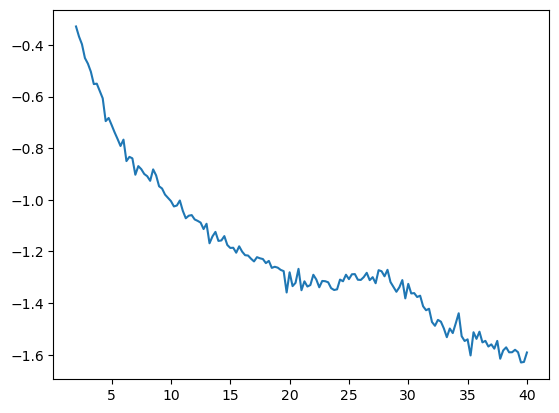

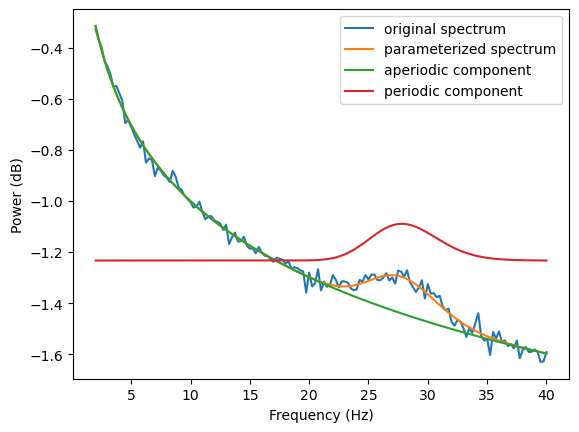

In [3]:
power_spectrum = np.load('../data/01_one-peak/single_peak_sims_psds.npy') # some power spectrum in linear space
power_spectrum = power_spectrum[1, 400, :] # take the first trial
print(power_spectrum.shape)
freqs = np.load('../data/01_one-peak/single_peak_sims_freqs.npy')
print(freqs.shape)

# load the ground truth values
ap_truths = np.load('../data/01_one-peak/single_peak_sims_ap_truths.npy')
peak_truths = np.load('../data/01_one-peak/single_peak_sims_peak_truths.npy')
print('peak truths:', peak_truths[1, 400,:])

# plot the power spectrum
plt.figure()
plt.plot(freqs, np.log10(power_spectrum))

param_spectra = ParamSpectra(bands='log',  max_n_peaks=1, log_freqs=True, n_division=1, l_freq=2, h_freq=40, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)

param_spectra.fit(freqs, power_spectrum)
output_params = param_spectra.get_params_out()
print(output_params)

plt.figure()
plt.plot(freqs, np.log10(power_spectrum), label='original spectrum')
plt.plot(freqs, param_spectra.modeled_spectrum_, label='parameterized spectrum')
plt.plot(freqs, param_spectra._ap_fit, label='aperiodic component')
plt.plot(freqs, param_spectra._peak_fit+np.mean(param_spectra._ap_fit), label='periodic component')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.show()



#         power_spectrum : 1d array
#             Power values, stored internally in log10 scale.
#         modeled_spectrum_ : 1d array
#             The full model fit of the power spectrum, in log10 scale.
#         aperiodic_params_ : 1d array
#             Parameters that define the aperiodic fit. As [Offset, (Knee), Exponent].
#             The knee parameter is only included if aperiodic component is fit with a knee.
#         peak_params_ : 2d array
#             Fitted parameter values for the peaks. Each row is a peak, as [CF, PW, BW].
#         gaussian_params_ : 2d array
#             Parameters that define the gaussian fit(s).
#             Each row is a gaussian, as [mean, height, standard deviation].
#         r_squared_ : float
#             R-squared of the fit between the input power spectrum and the full model fit.
#         error_ : float
#             Error of the full model fit.
#         n_peaks_ : int
#             The number of peaks fit in the model.



In [4]:
power_spectrum = np.load('../data/01_one-peak/single_peak_sims_psds.npy') # some power spectrum in linear space
freqs = np.load('../data/01_one-peak/single_peak_sims_freqs.npy')
print(power_spectrum.shape)
# load the ground truth values
ap_truths = np.load('../data/01_one-peak/single_peak_sims_ap_truths.npy')
peak_truths = np.load('../data/01_one-peak/single_peak_sims_peak_truths.npy')

# define arrays to store the output parameters: aperiodic_params, peak_params, r_squared, error
aperiodic_params_all = np.zeros((power_spectrum.shape[0], power_spectrum.shape[1], 3))
peak_params_all = np.zeros((power_spectrum.shape[0], power_spectrum.shape[1], 3))
r_squared_all = np.zeros((power_spectrum.shape[0], power_spectrum.shape[1]))
error_all = np.zeros((power_spectrum.shape[0], power_spectrum.shape[1]))

# fit and find the parameters
for noise_lvl in range(power_spectrum.shape[0]):
    for trial in range(power_spectrum.shape[1]):
        param_spectra = ParamSpectra(bands='log',  max_n_peaks=1, log_freqs=True, n_division=1, l_freq=2, h_freq=40, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)
        power_spectrum_trial = power_spectrum[noise_lvl, trial, :]
        param_spectra.fit(freqs, power_spectrum_trial)
        output_params = param_spectra.get_params_out()

        aperiodic_params = output_params['aperiodic_params']
        peak_params = output_params['peak_params']
        
        # reshape peak_params to be 3 columns
        peak_params = peak_params.reshape(-1, 3)

        # peak the row with highes =t value in second column
        peak_params = peak_params[np.argmax(peak_params[:, 1]), :]
        # bring the values of peakparams to linear scale
        peak_params[0] = np.exp(peak_params[0])
        peak_params[2] = np.exp(peak_params[2])

        r_squared = output_params['r_squared']
        error = output_params['error']
        # print('aperiodic params:', aperiodic_params)
        # print('peak params:', peak_params)
        
        # storing the output parameters
        aperiodic_params_all[noise_lvl, trial, :] = aperiodic_params
        peak_params_all[noise_lvl, trial, :] = peak_params
        r_squared_all[noise_lvl, trial] = r_squared
        error_all[noise_lvl, trial] = error
    print('Fitting with noise level:', {noise_lvl})

# save the output parameters
np.save('../data/01_one-peak/aperiodic_params_all_log_npeak1_AT.npy', aperiodic_params_all)
np.save('../data/01_one-peak/peak_params_all_log_npeak1_AT.npy', peak_params_all)
np.save('../data/01_one-peak/r_squared_all_log_npeak1_AT.npy', r_squared_all)
np.save('../data/01_one-peak/error_all_log_npeak1_AT.npy', error_all)



(5, 1000, 153)
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak parameters: [[2.76313039 0.38559128 0.23562826]]
Peak 0: CF: 15.849380048352748, PW: 0.3855912788503352, BW: 1.2657037118241619
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak parameters: [[2.88809136 0.24932507 0.11064511]]
Peak 0: CF: 17.958999562189856, PW: 0.2493250699521874, BW: 1.1169984216869984
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak parameters: [[2.19134904 0.28334293 0.45579826]]
Peak 0: CF: 8.947275201887402, PW: 0.2833429345887135, BW: 1.5774320803318709
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak parameters: [[3.208108   0.14630287 0.22821075]]
Peak 0: CF: 24.732248456183537, PW: 0.1463028725170088, BW: 1.2563500765732185
Using bands: [(1.9999999999999998, 39.999999999999

In [6]:
# load the output parameters
aperiodic_params_all = np.load('../data/01_one-peak/aperiodic_params_all_log_npeak1_AT.npy')
peak_params_all = np.load('../data/01_one-peak/peak_params_all_log_npeak1_AT.npy')
r_squared_all = np.load('../data/01_one-peak/r_squared_all_log_npeak1_AT.npy')
error_all = np.load('../data/01_one-peak/error_all_log_npeak1_AT.npy')

print(aperiodic_params_all.shape)
# throw away the column 1 of aperiodic_params_all
aperiodic_params_all = np.delete(aperiodic_params_all, 1, axis=2)
print(aperiodic_params_all.shape)
peak_fits = peak_params_all
ap_fits = aperiodic_params_all
r2_fits = r_squared_all
err_fits = error_all


print('Peak Fit Results:')
print(peak_fits.shape)
print(ap_fits.shape)
print(err_fits.shape)
print(r2_fits.shape)


(5, 1000, 3)
(5, 1000, 2)
Peak Fit Results:
(5, 1000, 3)
(5, 1000, 2)
(5, 1000)
(5, 1000)
